<a href="https://colab.research.google.com/github/leehyunggeunkeun/pytorch-study/blob/master/pytorch_0427_%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#필요 라이브러리

#기본 
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as dsets #데이터셋 불러오기
import torchvision.transforms as transforms #데이터 전처리
from torch.utils.data import DataLoader #데이터 로더시에 필요
import matplotlib.pyplot as plt #시각화

In [2]:
#이미지라서 오래걸리니 gpu사용하자

USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


In [0]:
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [4]:
#데이터셋 불러오기

trans = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))  # 질문1 전처리 하는중에 차원 오류나는데 애초에 몇차원인지 아는방법은??
])

train_data = dsets.FashionMNIST('./data', train=True, transform=trans, download=True)

test_data = dsets.FashionMNIST('./data', train=False, transform=trans, download=True)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [5]:
train_val_ratio = 0.8
train_size = int(len(train_data) * train_val_ratio)
val_size = len(train_data) - train_size

# train set와 validation set로 나누자

train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])
print(len(train_dataset), len(val_dataset))

48000 12000


In [6]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [0]:
learning_rate = 0.01

In [0]:
train_loader=DataLoader(dataset=train_dataset,batch_size=64,shuffle=True)
val_loader=DataLoader(dataset=val_dataset,batch_size=64,shuffle=True) #질문2: 밸리데이션도 셔플 맞는지
test_loader=DataLoader(dataset=test_data,batch_size=64,shuffle=False)

In [9]:
class Fmnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10) # 질문3: 첨에 뜬금없이 60000인가 헷갈리다가 784 라는걸 알았는데 그걸 애초에 아는 방법은??? 몇 by몇 이미지인지 어디서확인??

    def forward(self, x):
        return self.linear(x)

In [0]:
#relu 함수이니까 he정규화 한번 해보자

def weights_init(m):
    if isinstance(m, nn.Linear): # 모델의 모든 MLP 레이어에 대해서
        nn.init.kaiming_normal_(m.weight) # Weight를 xavier_normal로 초기화
        print(m.weight)

In [11]:
model = Fmnist().to(device)
model.apply(weights_init)

Parameter containing:
tensor([[-0.0150,  0.1352, -0.0071,  ...,  0.0113,  0.0085, -0.0496],
        [ 0.0039,  0.0253, -0.0591,  ...,  0.0631, -0.0273,  0.0277],
        [ 0.0905,  0.0936, -0.0038,  ...,  0.0043, -0.0216, -0.0667],
        ...,
        [-0.0814,  0.0138,  0.0115,  ..., -0.0393,  0.0366, -0.1038],
        [-0.0645, -0.0775, -0.0344,  ..., -0.0236, -0.0331, -0.0384],
        [-0.0559, -0.0191,  0.0325,  ..., -0.0170,  0.0567, -0.0339]],
       device='cuda:0', requires_grad=True)


Fmnist(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

In [13]:
total_batch=len(train_loader)+len(val_loader)

train_losses = []
val_losses = []

epochs=10

for epoch in range(epochs+1):
    avg_cost=0
    for i,data in enumerate(train_loader):
        imgs,labels=data
        imgs=imgs.view(-1,28*28).to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        hypothesis=model(imgs)
        cost=criterion(hypothesis,labels)
        cost.backward()
        optimizer.step()
        train_losses.append(cost.item())


        avg_cost += cost/total_batch

    print('epoch:{} cost= {}'.format(epoch+1,avg_cost))

    for o,data in enumerate(val_loader):
        imgs,labels=data
        imgs=imgs.view(-1,28*28).to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        hypothesis=model(imgs)
        cost=criterion(hypothesis,labels)
        cost.backward()
        optimizer.step()
        val_losses.append(cost.item())


        avg_cost += cost/total_batch

    print('epoch:{} cost= {}'.format(epoch+1,avg_cost))
    print('-'*50)

epoch:1 cost= 0.5617455244064331
epoch:1 cost= 0.7010307908058167
--------------------------------------------------
epoch:2 cost= 0.5295794606208801
epoch:2 cost= 0.6597519516944885
--------------------------------------------------
epoch:3 cost= 0.5256407260894775
epoch:3 cost= 0.6645017266273499
--------------------------------------------------
epoch:4 cost= 0.5292627215385437
epoch:4 cost= 0.6617532968521118
--------------------------------------------------
epoch:5 cost= 0.5357294678688049
epoch:5 cost= 0.6644221544265747
--------------------------------------------------
epoch:6 cost= 0.503695011138916
epoch:6 cost= 0.6455655694007874
--------------------------------------------------
epoch:7 cost= 0.5305381417274475
epoch:7 cost= 0.6583596467971802
--------------------------------------------------
epoch:8 cost= 0.52967768907547
epoch:8 cost= 0.6740692257881165
--------------------------------------------------
epoch:9 cost= 0.511410653591156
epoch:9 cost= 0.6420431137084961
--

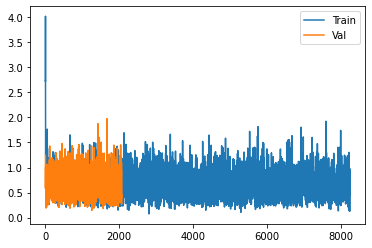

In [14]:
plt.plot(train_losses,label='Train')
plt.plot(val_losses,label='Val')
plt.legend()
plt.show()

In [15]:
with torch.no_grad():
    correct=0
    total=0
    
    for i,data in enumerate(test_loader):
        imgs,labels=data
        imgs=imgs.view(-1,28*28).to(device)
        labels=labels.to(device)

        prediction=model(imgs)
        _,argmax= torch.max(prediction,1)
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()
    
    print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))

Test accuracy for 10000 images: 80.62%
